In [9]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

# Matplot lib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# folium maps
import folium

# clustering algorithms from scikit learn
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

### Section 1: Web Scraper ###
Import the data from the webpage and save it as a new Beautiful Soup object _soup_

In [10]:
path = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(path)
assert(result.status_code == 200) # make sure the request came back positive from the server
soup = BeautifulSoup(result.content, 'html5lib')

In [11]:
table = soup.body.table
df = pd.DataFrame(columns = ['PostalCode', 'Borough', 'Neighbourhood'])

rows = table.findAll('tr')
for i, row in enumerate(rows):
    values = [x.getText().rstrip('\n') for x in row.findAll('td')]
    if len(values) > 0 : df.loc[i] = values

Extract the DataFrame with postcodes from the resulting list _wiki_, do some formatting and remove '_Not assigned_' values from the Borough column

In [12]:
df = df[df['Borough'] != 'Borough']
df = df[df['Borough'] != 'Not assigned']
df['Neighbourhood'] = np.where(df['Neighbourhood'] == 'Not assigned', df['Borough'], df['Neighbourhood'])
df.reset_index(drop=True, inplace=True)

codes = pd.DataFrame(df.groupby(['PostalCode', 'Borough'])['Neighbourhood'].apply(lambda x: "%s" % ', '.join(x)))
codes.reset_index(inplace=True) # Grouping the DataFrame made the columns Postcode and Borough the indices

### Section 2: Starting the Location Retrieval ###
I will use the provided .csv file

In [13]:
postal = pd.read_csv('https://cocl.us/Geospatial_data')
postal.columns = ['PostalCode', 'Latitude', 'Longitude']
locations = pd.merge(codes, postal, on='PostalCode', how='inner')
print(locations.shape)
locations.head(10)

(103, 5)


PostalCode      Borough                                    Neighbourhood  \
0        M1B  Scarborough                                   Rouge, Malvern   
1        M1C  Scarborough           Highland Creek, Rouge Hill, Port Union   
2        M1E  Scarborough                Guildwood, Morningside, West Hill   
3        M1G  Scarborough                                           Woburn   
4        M1H  Scarborough                                        Cedarbrae   
5        M1J  Scarborough                              Scarborough Village   
6        M1K  Scarborough      East Birchmount Park, Ionview, Kennedy Park   
7        M1L  Scarborough                  Clairlea, Golden Mile, Oakridge   
8        M1M  Scarborough  Cliffcrest, Cliffside, Scarborough Village West   
9        M1N  Scarborough                      Birch Cliff, Cliffside West   

    Latitude  Longitude  
0  43.806686 -79.194353  
1  43.784535 -79.160497  
2  43.763573 -79.188711  
3  43.770992 -79.216917  
4  43.773136 -79.239476  
5  43.744734 -79.239476  
6  43.727929 -79.262029  
7  43.711112 -79.284577  
8  43.716316 -79.239476  
9  43.692657 -79.264848

### Section 3: Neighbourhood Analysis ###
Let's have a look at the Boroughs and Neighbourhoods and create a Folium Map

In [14]:
geo_json = pd.read_json('toronto_crs84.geojson.txt', typ='series').to_json()

In [15]:
m = folium.Map(
    location=[locations.loc[44].Latitude, locations.loc[44].Longitude],
    zoom_start=11
)

# add markers to map
for latitude, longitude, borough, neighbourhood in zip(locations['Latitude'], locations['Longitude'], locations['Borough'], locations['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.Marker([latitude, longitude], popup=label).add_to(m)

# add neighbourhoods GeoJson
folium.GeoJson(geo_json).add_to(m)

m

We will use this fancy progress bar from stackoverflow to keep track of the progress of the query.

In [16]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

#### Section 3.1 Foursquare API ####
Let's get the data from Foursquare. We will just use the function _getNearbyVenues_ already provided.

In [17]:
CLIENT_ID, CLIENT_SECRET = pd.read_csv('foursquare credentials.txt')
VERSION = '20181019'

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    venues_list=[]
    i = 0
    for name, latitude, longitude in zip(names, latitudes, longitudes):
        printProgressBar(i, names.shape[0])
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            latitude,
            longitude,
            radius,
            limit)

        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            # retry once
            print('got a key error on url {}. ...retrying.'.format(url))
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            latitude, 
            longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        i+=1 # increase progress counter

    printProgressBar(1, 1)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                  'Neighbourhood Latitude',
                  'Neighbourhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category']

    return(nearby_venues)

In [21]:
venues = getNearbyVenues(locations.Neighbourhood, locations.Latitude, locations.Longitude)
print('\n ', venues.shape)
venues.head()

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

  (2253, 7)


Neighbourhood  Neighbourhood Latitude  \
0                          Rouge, Malvern               43.806686   
1                          Rouge, Malvern               43.806686   
2  Highland Creek, Rouge Hill, Port Union               43.784535   
3  Highland Creek, Rouge Hill, Port Union               43.784535   
4  Highland Creek, Rouge Hill, Port Union               43.784535   

   Neighbourhood Longitude                           Venue  Venue Latitude  \
0               -79.194353                         Wendy's       43.807448   
1               -79.194353           Interprovincial Group       43.805630   
2               -79.160497           Royal Canadian Legion       43.782533   
3               -79.160497       Affordable Toronto Movers       43.787919   
4               -79.160497  Scarborough Historical Society       43.788755   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.200378            Print Shop  
2       -79.163085                   Bar  
3       -79.162977         Moving Target  
4       -79.162438        History Museum

In [23]:
venue_count = pd.DataFrame(venues.groupby('Neighbourhood')['Venue'].count())
venue_count.head()

Venue
Neighbourhood                                            
Adelaide, King, Richmond                              100
Agincourt                                               4
Agincourt North, L'Amoreaux East, Milliken, Ste...      3
Albion Gardens, Beaumond Heights, Humbergate, J...      9
Alderwood, Long Branch                                 11

In [24]:
locations = pd.merge(locations, venue_count, on='Neighbourhood', how='inner')
locations.rename(columns = {'Venue':'No. of Venues'}, inplace=True)
print(locations.shape)
locations.head()

(101, 6)


PostalCode      Borough                           Neighbourhood   Latitude  \
0        M1B  Scarborough                          Rouge, Malvern  43.806686   
1        M1C  Scarborough  Highland Creek, Rouge Hill, Port Union  43.784535   
2        M1E  Scarborough       Guildwood, Morningside, West Hill  43.763573   
3        M1G  Scarborough                                  Woburn  43.770992   
4        M1H  Scarborough                               Cedarbrae  43.773136   

   Longitude  No. of Venues  
0 -79.194353              2  
1 -79.160497              3  
2 -79.188711              6  
3 -79.216917              4  
4 -79.239476              8

There are some neighbourhoods with only few venues. This is probably due to the size of the different neighbourhoods: central neighbourhoods are usually more crowded and have more venue per area. For less crowded neighbourhoods the centre we set for the search radius will highly influence the number of venues we get. But let's keept the data set like this first and let's see what happens.

#### Section 3.2: Data Preparation ####
Let's prepare the data for further analysis: First, we will encode the venues using pandas _get_dummies_ method to get rid of the string values.

In [25]:
dummies = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
venues_onehot = pd.concat([venues['Neighbourhood'], dummies], axis=1)
print('There are {} venues in {} different categories'.format(venues_onehot.shape[0], (venues_onehot.shape[1]-1)))
venues_onehot.head()

There are 2253 venues in 275 different categories


Neighbourhood  Accessories Store  Adult Boutique  \
0                          Rouge, Malvern                  0               0   
1                          Rouge, Malvern                  0               0   
2  Highland Creek, Rouge Hill, Port Union                  0               0   
3  Highland Creek, Rouge Hill, Port Union                  0               0   
4  Highland Creek, Rouge Hill, Port Union                  0               0   

   Afghan Restaurant  Airport  Airport Food Court  Airport Gate  \
0                  0        0                   0             0   
1                  0        0                   0             0   
2                  0        0                   0             0   
3                  0        0                   0             0   
4                  0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal     ...       \
0               0                0                 0     ...        
1               0                0                 0     ...        
2               0                0                 0     ...        
3               0                0                 0     ...        
4               0                0                 0     ...        

   Train Station  Vegetarian / Vegan Restaurant  Video Game Store  \
0              0                              0                 0   
1              0                              0                 0   
2              0                              0                 0   
3              0                              0                 0   
4              0                              0                 0   

   Video Store  Vietnamese Restaurant  Warehouse Store  Wine Bar  Wings Joint  \
0            0                      0                0         0            0   
1            0                      0                0         0            0   
2            0                      0                0         0            0   
3            0                      0                0         0            0   
4            0                      0                0         0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 276 columns]

Now we group this DataFrame again by neighbourhood and get a distribution of venues types per neighbourhood. This will result in a vector with 101 rows (the neighbourhoods) and 276 columns (neighbourhood column + 275 venue types). This DataFrame is very sparse, though: Some neighbourhoods only have few venues and many venues types typically exist in only one or two neighbourhoods per city, like airports.

In [26]:
frequencies = venues_onehot.groupby('Neighbourhood').mean().reset_index()
print(frequencies.shape)
frequencies.head()

(101, 276)


Neighbourhood  Accessories Store  \
0                           Adelaide, King, Richmond               0.01   
1                                          Agincourt               0.00   
2  Agincourt North, L'Amoreaux East, Milliken, St...               0.00   
3  Albion Gardens, Beaumond Heights, Humbergate, ...               0.00   
4                             Alderwood, Long Branch               0.00   

   Adult Boutique  Afghan Restaurant  Airport  Airport Food Court  \
0             0.0                0.0      0.0                 0.0   
1             0.0                0.0      0.0                 0.0   
2             0.0                0.0      0.0                 0.0   
3             0.0                0.0      0.0                 0.0   
4             0.0                0.0      0.0                 0.0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0           0.0             0.0              0.0               0.0   
1           0.0             0.0              0.0               0.0   
2           0.0             0.0              0.0               0.0   
3           0.0             0.0              0.0               0.0   
4           0.0             0.0              0.0               0.0   

      ...       Train Station  Vegetarian / Vegan Restaurant  \
0     ...                 0.0                           0.01   
1     ...                 0.0                           0.00   
2     ...                 0.0                           0.00   
3     ...                 0.0                           0.00   
4     ...                 0.0                           0.00   

   Video Game Store  Video Store  Vietnamese Restaurant  Warehouse Store  \
0               0.0          0.0                    0.0              0.0   
1               0.0          0.0                    0.0              0.0   
2               0.0          0.0                    0.0              0.0   
3               0.0          0.0                    0.0              0.0   
4               0.0          0.0                    0.0              0.0   

   Wine Bar  Wings Joint  Women's Store  Yoga Studio  
0      0.01          0.0           0.01          0.0  
1      0.00          0.0           0.00          0.0  
2      0.00          0.0           0.00          0.0  
3      0.00          0.0           0.00          0.0  
4      0.00          0.0           0.00          0.0  

[5 rows x 276 columns]

#### Side topic ####
Let's have a look at the top venues per neighbourhood. We will use one of the functions provided but change it slightly in order to account for neighbourhoods with only few venues. Otherwise the result is pretty arbitrary.

In [27]:
def return_actual_most_common_venues(categories, num_top_venues):
    categories_sorted = categories[1:].sort_values(ascending=False)
    top_venues = categories_sorted.index.values[0:num_top_venues]
    for i, venue in enumerate(top_venues):
        if not(categories_sorted[i] > 0): top_venues[i] = ""

    return top_venues

In [28]:
num_top_venues = 10

# create columns according to number of top venues
columns = ['Neighbourhood', 'No. of Venues']
for ind in np.arange(num_top_venues):
    columns.append('{}. Most Common Venue'.format(ind+1))

# create a new dataframe
top_venues = pd.DataFrame(columns=columns)
top_venues['Neighbourhood'] = frequencies['Neighbourhood']
top_venues['No. of Venues'] = venue_count.values

for ind in np.arange(frequencies.shape[0]):
    top_venues.iloc[ind, 2:] = return_actual_most_common_venues(frequencies.iloc[ind], num_top_venues)

top_venues

Neighbourhood  No. of Venues  \
0                             Adelaide, King, Richmond            100   
1                                            Agincourt              4   
2    Agincourt North, L'Amoreaux East, Milliken, St...              3   
3    Albion Gardens, Beaumond Heights, Humbergate, ...              9   
4                               Alderwood, Long Branch             11   
5      Bathurst Manor, Downsview North, Wilson Heights             19   
6                                      Bayview Village              4   
7                    Bedford Park, Lawrence Manor East             26   
8                                          Berczy Park             53   
9                          Birch Cliff, Cliffside West              4   
10   Bloordale Gardens, Eringate, Markland Wood, Ol...              6   
11        Brockton, Exhibition Place, Parkdale Village             21   
12    Business reply mail Processing Centre969 Eastern             17   
13                         CFB Toronto, Downsview East              3   
14   CN Tower, Bathurst Quay, Island airport, Harbo...             14   
15                         Cabbagetown, St. James Town             48   
16                                 Caledonia-Fairbanks              6   
17               Canada Post Gateway Processing Centre             11   
18                                           Cedarbrae              8   
19                                  Central Bay Street             82   
20           Chinatown, Grange Park, Kensington Market            100   
21                                            Christie             16   
22                                Church and Wellesley             88   
23                     Clairlea, Golden Mile, Oakridge              9   
24             Clarks Corners, Sullivan, Tam O'Shanter             10   
25     Cliffcrest, Cliffside, Scarborough Village West              3   
26   Cloverdale, Islington, Martin Grove, Princess ...              1   
27                      Commerce Court, Victoria Hotel            100   
28                                          Davisville             38   
29                                    Davisville North              8   
..                                                 ...            ...   
71                     Northwood Park, York University              6   
72                              Parkdale, Roncesvalles             14   
73                                           Parkwoods              3   
74                                        Queen's Park             42   
75                                            Rosedale              4   
76                                            Roselawn              2   
77                                      Rouge, Malvern              2   
78                                  Runnymede, Swansea             36   
79                            Ryerson, Garden District            100   
80                                 Scarborough Village              3   
81                            Silver Hills, York Mills              1   
82                                      St. James Town            100   
83                     Stn A PO Boxes 25 The Esplanade             92   
84                                     Studio District             41   
85                 The Annex, North Midtown, Yorkville             25   
86                                         The Beaches              3   
87                      The Beaches West, India Bazaar             20   
88                        The Danforth West, Riverdale             42   
89                       The Junction North, Runnymede              4   
90       The Kingsway, Montgomery Road, Old Mill North              2   
91                                    Thorncliffe Park             16   
92                                    Victoria Village              5   
93                                           Westmount              7   
94                        

#### 3.3 Data Analysis ####
__Let's cluster!__ Let's run k-means with a couple of different *k* and see what we get. We will run the algorithm for each k 1000 times (so 1000 different random centroids) for up to 10,000 iterations - this might take a while but ensures stable results.

In [29]:
max_k = 50
kmeans = {}

for k in range(2, max_k):
    printProgressBar(k-1, max_k-2)
    kmeans[k] = KMeans(n_clusters=k, n_init=1000, max_iter=10000, n_jobs=-1).fit(frequencies.iloc[:, 1:])

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


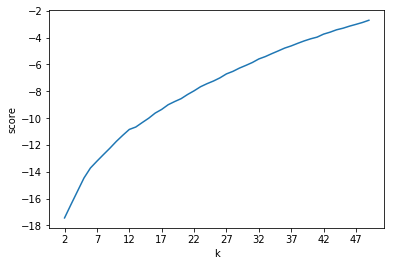

In [30]:
plt.plot(range(2, max_k), [kmeans[k].score(frequencies.iloc[:, 1:]) for k in kmeans])
plt.xticks(range(2, max_k, 5))
plt.xlabel('k')
plt.ylabel('score')
plt.show()

In [31]:
# we will use this helper function along the analysis
def showClusterDistribution(clusters):
    '''
    Count the number of neighbourhoods in each cluster and return an ordered list.
    '''
    distribution = pd.value_counts(pd.Series(clusters))
    return pd.DataFrame(distribution).transpose().sort_values(by=0, ascending=False, axis=1)

In [32]:
showClusterDistribution(kmeans[6].labels_)

0   1  4  3  5  2
0  82  13  2  2  1  1

Looking at the plot we see that the error decreases with increasing k and we might see a kink in the plot somewhere around k=6. However, it is not completely clear from that plot, which k to choose. The plot might as well suggest that there are no clusters in our data.

Let's also try a density-based method: DBSAN. We will set the parameter *min_samples* to 1 so even a single neighbourhood is assigned to some cluster and not marked as an outlier. We will have to vary the *epsilon* parameter in order to adjust the number of resulting clusters. What we want is some useful distribution: cluster sizes of up to 10 neighbourhoods would probably be fine as well as several clusters with at least 3 neighbourhoods.

In [33]:
cluster = DBSCAN(eps=.5, min_samples=1).fit_predict(frequencies.iloc[:, 1:])
showClusterDistribution(cluster)

0   20  19  18  17  16  15  14  13  12 ...  9   8   7   6   5   4   3   2   \
0  80   1   1   1   1   1   1   1   1   1 ...   1   1   1   1   1   1   1   1   

   1   10  
0   1   1  

[1 rows x 22 columns]

### 3.4 Discussion and next steps (further analysis) ###
The results are poor for DBSCAN. We get just one huge cluster and changing epsilon does not solve this issue. This suggests as well that there are no clusters in our data. So let's try to get some more venues for the less crowded neighbourhoods by increasing the search radius. Let's do so, until we get 80 venues (this number is chosen randomly - varying this value would lead to different results). So, for crowded areas we might get 100 venues from foursquare, for others only 80.

In [34]:
def get80NearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    venues_list=[]
    i = 0

    for name, latitude, longitude in zip(names, latitudes, longitudes):
        results = []
        r = radius
        printProgressBar(i, names.shape[0])
        while len(results) < 80:
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID,
                CLIENT_SECRET,
                VERSION,
                latitude,
                longitude,
                r,
                limit)

            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
            except KeyError:
                # retry once
                print('got a key error on url {}. ...retrying.'.format(url))
                results = requests.get(url).json()["response"]['groups'][0]['items']

            r+= 100

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            latitude, 
            longitude, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            r) for v in results])
        
        i+=1 # increase progress counter

    printProgressBar(1, 1)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                  'Neighbourhood Latitude',
                  'Neighbourhood Longitude',
                  'Venue',
                  'Venue Latitude',
                  'Venue Longitude',
                  'Venue Category',
                  'Search Radius']

    return(nearby_venues)

In [35]:
venues_80 = get80NearbyVenues(locations.Neighbourhood, locations.Latitude, locations.Longitude)
print('\n ', venues_80.shape)
venues_80.head(10)

got a key error on url https://api.foursquare.com/v2/venues/explore?&client_id=ONEKSAOACWSXWCOZWVWVHT0HTLH4XJSY4DR0JCXQDKJRY5MZ&client_secret= TC0UZ5GAT0PR0TELM5ELQR0GR5QU30LLJVKBM55OYPXMRSOR&v=20181019&ll=43.6489597,-79.456325&radius=900&limit=100. ...retrying.
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

  (8942, 8)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Rouge, Malvern               43.806686               -79.194353   
1  Rouge, Malvern               43.806686               -79.194353   
2  Rouge, Malvern               43.806686               -79.194353   
3  Rouge, Malvern               43.806686               -79.194353   
4  Rouge, Malvern               43.806686               -79.194353   
5  Rouge, Malvern               43.806686               -79.194353   
6  Rouge, Malvern               43.806686               -79.194353   
7  Rouge, Malvern               43.806686               -79.194353   
8  Rouge, Malvern               43.806686               -79.194353   
9  Rouge, Malvern               43.806686               -79.194353   

                          Venue  Venue Latitude  Venue Longitude  \
0   African Rainforest Pavilion       43.817725       -79.183433   
1  Toronto Pan Am Sports Centre       43.790623       -79.193869   
2                   Toronto Zoo       43.820582       -79.181551   
3             Canadiana exhibit       43.817894       -79.193260   
4            Polar Bear Exhibit       43.823372       -79.185145   
5             Orangutan Exhibit       43.818413       -79.182548   
6         Australasia Pavillion       43.822563       -79.183286   
7               penguin exhibit       43.819435       -79.185959   
8                   BeaverTails       43.823376       -79.184616   
9             Americas Pavillon       43.822083       -79.185665   

       Venue Category  Search Radius  
0         Zoo Exhibit           4100  
1  Athletics & Sports           4100  
2                 Zoo           4100  
3         Zoo Exhibit           4100  
4                 Zoo           4100  
5         Zoo Exhibit           4100  
6         Zoo Exhibit           4100  
7         Zoo Exhibit           4100  
8        Dessert Shop           4100  
9         Zoo Exhibit           4100

In [36]:
dummies_80 = pd.get_dummies(venues_80[['Venue Category']], prefix="", prefix_sep="")
venues_80_onehot = pd.concat([venues_80['Neighbourhood'], dummies_80], axis=1)
frequencies_80 = venues_80_onehot.groupby('Neighbourhood').mean().reset_index()

print('There are {} venues in {} different categories'.format(venues_80_onehot.shape[0], (venues_80_onehot.shape[1]-1)))
frequencies_80.head()

There are 8942 venues in 363 different categories


Neighbourhood  Accessories Store  \
0                           Adelaide, King, Richmond               0.01   
1                                          Agincourt               0.00   
2  Agincourt North, L'Amoreaux East, Milliken, St...               0.00   
3  Albion Gardens, Beaumond Heights, Humbergate, ...               0.00   
4                             Alderwood, Long Branch               0.00   

   Adult Boutique  Afghan Restaurant  African Restaurant  Airport  \
0             0.0                0.0                 0.0      0.0   
1             0.0                0.0                 0.0      0.0   
2             0.0                0.0                 0.0      0.0   
3             0.0                0.0                 0.0      0.0   
4             0.0                0.0                 0.0      0.0   

   Airport Lounge  American Restaurant  Amphitheater  Animal Shelter  \
0             0.0                 0.04           0.0             0.0   
1             0.0                 0.02           0.0             0.0   
2             0.0                 0.00           0.0             0.0   
3             0.0                 0.00           0.0             0.0   
4             0.0                 0.00           0.0             0.0   

      ...       Volleyball Court  Warehouse Store  Wine Bar  Wine Shop  \
0     ...                    0.0              0.0      0.01        0.0   
1     ...                    0.0              0.0      0.00        0.0   
2     ...                    0.0              0.0      0.00        0.0   
3     ...                    0.0              0.0      0.00        0.0   
4     ...                    0.0              0.0      0.00        0.0   

   Wings Joint  Women's Store  Xinjiang Restaurant  Yoga Studio  Zoo  \
0     0.000000           0.01                  0.0          0.0  0.0   
1     0.010000           0.00                  0.0          0.0  0.0   
2     0.000000           0.00                  0.0          0.0  0.0   
3     0.000000           0.00                  0.0          0.0  0.0   
4     0.023256           0.00                  0.0          0.0  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 364 columns]

#### 3.4.1 k-means Clustering ####

In [37]:
max_k = 50
kmeans_80 = {}

for k in range(2, max_k):
    printProgressBar(k-2, max_k-2)
    kmeans_80[k] = KMeans(n_clusters=k, n_init=1000, max_iter=10000, n_jobs=-1).fit(frequencies_80.iloc[:, 1:])
printProgressBar(1, 1)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


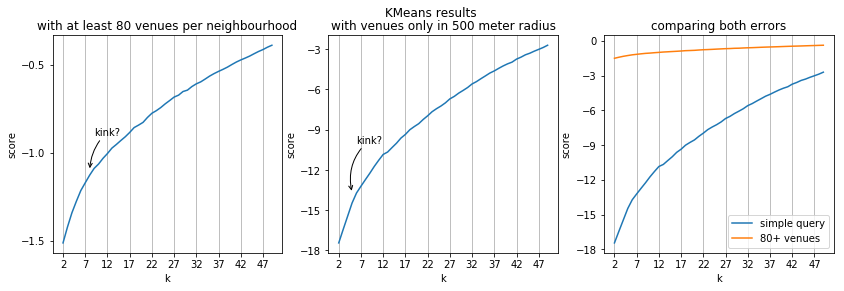

In [38]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
fig.suptitle('KMeans results')

ax = axs[0]
ax.plot(range(2, 50), [kmeans_80[k].score(frequencies_80.iloc[:, 1:]) for k in kmeans_80])
ax.set_xticks(range(2, 50, 5))
ax.set_yticks([-1.5, -1, -0.5])
ax.set_xlabel('k')
ax.set_ylabel('score')
ax.grid(True, axis='x')
ax.set_title('with at least 80 venues per neighbourhood')

ax.annotate('kink?', xy=(8, -1.1), xytext=(9, -0.9), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"))

ax = axs[1]
ax.plot(range(2, 50), [kmeans[k].score(frequencies.iloc[:, 1:]) for k in kmeans])
ax.set_xticks(range(2, 50, 5))
ax.set_yticks(range(-18, 0, 3))
ax.set_xlabel('k')
ax.set_ylabel('score')
ax.grid(True, axis='x')
ax.set_title('with venues only in 500 meter radius')

ax.annotate('kink?', xy=(5, -13.7), xytext=(6, -10), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3"))

ax = axs[2]
ax.plot(range(2, 50), [kmeans[k].score(frequencies.iloc[:, 1:]) for k in kmeans])
ax.plot(range(2, 50), [kmeans_80[k].score(frequencies_80.iloc[:, 1:]) for k in kmeans_80])
ax.set_xticks(range(2, 50, 5))
ax.set_yticks(range(-18, 1, 3))
ax.set_xlabel('k')
ax.set_ylabel('score')
ax.grid(True, axis='x')
ax.set_title('comparing both errors')
ax.legend(['simple query', '80+ venues'])

plt.show()

In [39]:
showClusterDistribution(kmeans_80[8].labels_)

4   1   0   2   3  7  5  6
0  21  20  20  19  11  4  4  2

We see that the error is much smaller with at least 80 venues than it is with the first approach of only searching the 500 meter perimeter. The error curve's shapes look pretty similar, though. It is still not clear how to choose the right size of clusters that represents the internal structure of the data.
#### 3.4.2 DBSCAN clustering ####

In [40]:
frequencies_80_cluster = DBSCAN(eps=0.125, min_samples=1).fit_predict(frequencies_80.iloc[:,1:])
showClusterDistribution(frequencies_80_cluster)

3   5   0   8   21  4   9   14  15  1  ...  11  18  37  7   6   40  41  17  \
0  25  18   8   3   3   2   2   2   2   2 ...   1   1   1   1   1   1   1   1   

   19  43  
0   1   1  

[1 rows x 44 columns]

Let's have a look at that result on the map: we will only choose 'real' clusters with at least two neighbourhoods.

In [41]:
# another helper function
def getClusterSelection(clusters, frequencies):
    '''
    Returns only those neighbourhoods from the frequencies data set that are clustered with at least one other neighbourhood.
    '''
    cluster_counts = showClusterDistribution(clusters)
    selection = cluster_counts.iloc[0][cluster_counts.iloc[0] > 1]
    selection = pd.concat([frequencies, pd.DataFrame(clusters)], axis=1)[[c in selection for c in clusters]][['Neighbourhood', 0]]
    return pd.merge(locations, selection, on='Neighbourhood', how='inner')

In [42]:
# as we will look at a couple of maps let's define another helper function
def showAnnotatedMap(map_centre, zoom_start, num_of_colours, selection):
    '''
    Shows a folium map with markers for the different clusters in different colours.
    
    selection -> DataFrame with the clusters to show on the map.
    '''
    m = folium.Map(
        location=[locations.loc[map_centre].Latitude, locations.loc[map_centre].Longitude],
        zoom_start=zoom_start
    )

    # set color scheme for the clusters
    x = np.arange(num_of_colours)
    ys = [i+x+(i*x)**2 for i in range(num_of_colours)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add neighbourhoods GeoJson
    folium.GeoJson(geo_json).add_to(m)

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(selection['Latitude'], selection['Longitude'], selection['Neighbourhood'], selection[0]):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(m)

    return m

In [43]:
# k-means map with k=8
showAnnotatedMap(44, 11, 7, getClusterSelection(kmeans_80[8].labels_, frequencies_80))

In [44]:
# DBSCAN map
showAnnotatedMap(44, 11, 21, getClusterSelection(frequencies_80_cluster, frequencies_80))

Well, that looks interesting! We can indeed identify several clusters - one of them seems to be the town centre (the red cluster 0).

#### 3.4.4 Next steps ####
The shape of the k-means error curve still suggests that there are no clusters in our data which is not unlikely given the data set: there are 101 points (neighbourhoods) spread across over 350 dimensions (the venue types). The results from the DBSCAN clustering are better than with the first try but still not really what we wanted: we still get a large number of unclustered neighbourhoods. Perhaps we can get more meaningful results if we only look at the central neighbourhoods of Toronto. We will choose only those neighbourhoods in boroughs that include the name _Toronto_.

In [45]:
Toronto_neighbourhoods_cover = ['toronto' in b.lower() for b in locations.Borough]
Toronto_neighbourhoods = locations.Neighbourhood[Toronto_neighbourhoods_cover]

Toronto_frequencies = frequencies_80.loc[frequencies_80.Neighbourhood.isin(Toronto_neighbourhoods)].reset_index(drop=True)
print(Toronto_frequencies.shape)
Toronto_frequencies.head()

(38, 364)


Neighbourhood  Accessories Store  \
0                           Adelaide, King, Richmond           0.010000   
1                                        Berczy Park           0.000000   
2       Brockton, Exhibition Place, Parkdale Village           0.011765   
3   Business reply mail Processing Centre969 Eastern           0.000000   
4  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   

   Adult Boutique  Afghan Restaurant  African Restaurant  Airport  \
0             0.0                0.0                 0.0  0.00000   
1             0.0                0.0                 0.0  0.00000   
2             0.0                0.0                 0.0  0.00000   
3             0.0                0.0                 0.0  0.00000   
4             0.0                0.0                 0.0  0.01087   

   Airport Lounge  American Restaurant  Amphitheater  Animal Shelter  \
0         0.00000             0.040000           0.0             0.0   
1         0.00000             0.011628           0.0             0.0   
2         0.00000             0.000000           0.0             0.0   
3         0.00000             0.024691           0.0             0.0   
4         0.01087             0.000000           0.0             0.0   

      ...       Volleyball Court  Warehouse Store  Wine Bar  Wine Shop  \
0     ...                    0.0              0.0      0.01        0.0   
1     ...                    0.0              0.0      0.00        0.0   
2     ...                    0.0              0.0      0.00        0.0   
3     ...                    0.0              0.0      0.00        0.0   
4     ...                    0.0              0.0      0.00        0.0   

   Wings Joint  Women's Store  Xinjiang Restaurant  Yoga Studio  Zoo  \
0     0.000000           0.01                  0.0     0.000000  0.0   
1     0.000000           0.00                  0.0     0.000000  0.0   
2     0.000000           0.00                  0.0     0.011765  0.0   
3     0.000000           0.00                  0.0     0.000000  0.0   
4     0.021739           0.00                  0.0     0.010870  0.0   

   Zoo Exhibit  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 364 columns]

Drop columns with venues that do no longer exist in this data set.

In [46]:
Toronto_frequencies.drop([col for col, val in Toronto_frequencies.sum().iteritems() if val == 0], axis=1, inplace=True)
print(Toronto_frequencies.shape)
Toronto_frequencies.head()

(38, 283)


Neighbourhood  Accessories Store  \
0                           Adelaide, King, Richmond           0.010000   
1                                        Berczy Park           0.000000   
2       Brockton, Exhibition Place, Parkdale Village           0.011765   
3   Business reply mail Processing Centre969 Eastern           0.000000   
4  CN Tower, Bathurst Quay, Island airport, Harbo...           0.000000   

   Adult Boutique  Afghan Restaurant  Airport  Airport Lounge  \
0             0.0                0.0  0.00000         0.00000   
1             0.0                0.0  0.00000         0.00000   
2             0.0                0.0  0.00000         0.00000   
3             0.0                0.0  0.00000         0.00000   
4             0.0                0.0  0.01087         0.01087   

   American Restaurant  Amphitheater  Animal Shelter  Antique Shop ...   \
0             0.040000           0.0             0.0      0.000000 ...    
1             0.011628           0.0             0.0      0.011628 ...    
2             0.000000           0.0             0.0      0.000000 ...    
3             0.024691           0.0             0.0      0.012346 ...    
4             0.000000           0.0             0.0      0.000000 ...    

    Tunnel  Vegetarian / Vegan Restaurant  Video Game Store  Video Store  \
0  0.00000                       0.010000               0.0          0.0   
1  0.00000                       0.000000               0.0          0.0   
2  0.00000                       0.023529               0.0          0.0   
3  0.00000                       0.000000               0.0          0.0   
4  0.01087                       0.000000               0.0          0.0   

   Vietnamese Restaurant  Wine Bar  Wings Joint  Women's Store  Yoga Studio  \
0               0.000000      0.01     0.000000           0.01     0.000000   
1               0.000000      0.00     0.000000           0.00     0.000000   
2               0.000000      0.00     0.000000           0.00     0.011765   
3               0.012346      0.00     0.000000           0.00     0.000000   
4               0.000000      0.00     0.021739           0.00     0.010870   

   Zoo  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows x 283 columns]

In [47]:
max_k = Toronto_frequencies.shape[0]
Toronto_kmeans = {}

for k in range(2, max_k):
    printProgressBar(k-1, max_k-2)
    Toronto_kmeans[k] = KMeans(n_clusters=k, n_init=1000, max_iter=10000, n_jobs=-1).fit(Toronto_frequencies.iloc[:, 1:])

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


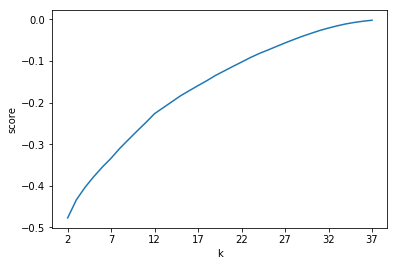

In [48]:
plt.plot(range(2, max_k), [Toronto_kmeans[k].score(Toronto_frequencies.iloc[:, 1:]) for k in Toronto_kmeans])
plt.xticks(range(2, max_k, 5))
plt.xlabel('k')
plt.ylabel('score')
plt.show()

In [49]:
Toronto_frequencies_cluster = DBSCAN(eps=0.129, min_samples=1).fit_predict(Toronto_frequencies.iloc[:,1:])
showClusterDistribution(Toronto_frequencies_cluster)

9   0   1   13  2   15  14  12  11  10  17  5   8   6   4   3   7   16  18
0   9   8   3   2   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1

In [50]:
# k-means map with k = 7
showAnnotatedMap(50, 12, 6, getClusterSelection(Toronto_kmeans[7].labels_, Toronto_frequencies))

In [51]:
# DBSCAN map
showAnnotatedMap(50, 12, 13, getClusterSelection(Toronto_frequencies_cluster, Toronto_frequencies))

This looks pretty neat!

The number of clusters is still just a guess, though, as there does not seem to be an inherent structure. The results are not very stable: for DBSCAN only slight changes in epsilon lead to completely different results and for k-means we cannot decide what stop criterion to use to decide which k to use. We can, however, compare the results with the map and then decide whether to coarsen or refine the clusters.